# Contact Maps

Contact Map Explorer includes some tricks to study contact maps in protein dynamics, based on tools in MDTraj. This notebook shows examples and serves as documentation.

As an example, we'll use part of a trajectory of the KRas protein bound to GTP, which was provided by Sander Roet. KRas is a protein that plays a role in many cancers. For simplicity, the waters were removed from the trajectory (although ions are still included). To run this notebook, download the example files from https://figshare.com/s/453b1b215cf2f9270769 (total download size about 1.2 MB). Download all files, and extract in the same directory that you started Jupyter from (so that you have a directory called `5550217` in your current working directory).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import mdtraj as md
traj = md.load("5550217/kras.xtc", top="5550217/kras.pdb")
topology = traj.topology

In [2]:
from contact_map import ContactMap, ContactFrequency, ContactDifference

## Look at a single frame: `ContactMap`

First we make the contact map for the 0th frame. For default parameters (and how to change them) see section "Changing the defaults" below.

In [3]:
%%time
frame_contacts = ContactMap(traj[0])

CPU times: user 441 ms, sys: 15.1 ms, total: 456 ms
Wall time: 90.5 ms


The built-in plotter requires one of the [matplotlib color maps](https://matplotlib.org/users/colormaps.html) the set the color scheme. If you select a divergent color map (useful if you want to look at contact differences), then you should give the parameters `vmin=-1`, and `vmax=1`. Otherwise, you should use `vmin=0` and `vmax=1`.

CPU times: user 2.25 s, sys: 38.1 ms, total: 2.29 s
Wall time: 583 ms


Text(0, 0.5, 'Residue')

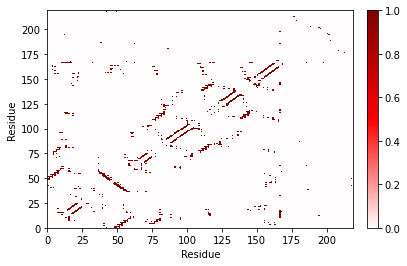

In [4]:
%%time
(fig, ax) = frame_contacts.residue_contacts.plot(cmap='seismic', vmin=-1, vmax=1)
plt.xlabel("Residue")
plt.ylabel("Residue")

The plotting function return the `matplotlib` `Figure` and `Axes` objects, which allow you to make more manipulations to them later. I'll show an example of that in the "Changing the defaults" section.

We can also plot the atom-atom contacts, although it takes a little time. The built-in plotting function is best if there are not many contacts (if the matrix is sparse). If there are lots of contacts, sometimes other approaches can plot more quickly. See an example in the "Changing the defaults" section.

/home/sander/github_files/contact_map/contact_map/contact_count.py:175: RuntimeWarning: The number of pixels in the figure is insufficient to show all the contacts.
 Please save this as a vector image (such as a PDF) to view the correct result.
 Another option is to increase the 'dpi' (currently: 72.0), or the 'figsize' (currently: (6.0, 4.0)).
 Recommended minimum amount of pixels = (2722, 2722) (width, height).
  warnings.warn(msg, RuntimeWarning)


CPU times: user 3.02 s, sys: 24.4 ms, total: 3.05 s
Wall time: 3.04 s


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc7e6bf3050>)

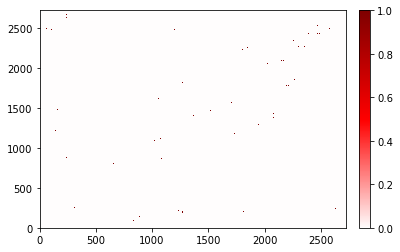

In [5]:
%%time
frame_contacts.atom_contacts.plot(cmap='seismic', vmin=-1, vmax=1);

You'll notice that you don't see many points here. As the warning states: That is because the points are smaller than a single pixel at this resolution. To fix that, output or save this figure as a vector image (like PDF), increase the figure's size (by using the `figsize` parameter) or dpi (by using the `dpi` parameter), or both. 

In [6]:
# If you want Jupyter to output pdf, instead of png:
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('pdf')
# frame_contacts.atom_contacts.plot(cmap='seismic', vmin=-1, vmax=1);

# If you want to save as a vector image:
# frame_contacts.atom_contacts.plot(cmap='seismic', vmin=-1, vmax=1);
# plt.savefig('atom_contacts.pdf')

# If you want to increase the figure size:
# frame_contacts.atom_contacts.plot(cmap='seismic', vmin=-1, vmax=1, figsize=(38, 38));

# If you want to increase the dpi (and make the image square):
# frame_contacts.atom_contacts.plot(cmap='seismic', vmin=-1, vmax=1, figsize=(6, 6), dpi=454);

## Look at a trajectory: `ContactFrequency`

`ContactFrequency` finds the fraction of frames where each contact exists.

In [7]:
%%time
trajectory_contacts = ContactFrequency(traj)

CPU times: user 40.2 s, sys: 821 ms, total: 41 s
Wall time: 3.66 s


In [8]:
# if you want to save this for later analysis
trajectory_contacts.save_to_file("traj_contacts.p")
# then load with ContactFrequency.from_file("traj_contacts.p")

CPU times: user 2.74 s, sys: 44.1 ms, total: 2.79 s
Wall time: 1.94 s


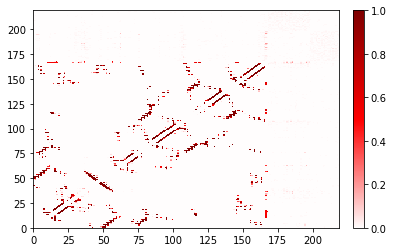

In [9]:
%%time
fig, ax = trajectory_contacts.residue_contacts.plot(cmap='seismic', vmin=-1, vmax=1);

## Compare two: `ContactDifference`

If you want to compare two frequencies, you can use the `ContactDifference` class (or the shortcut for it, which is to subtract a contact frequency/map from another.)

The example below will compare the trajectory to its first frame.

In [10]:
%%time
diff = trajectory_contacts - frame_contacts

CPU times: user 21.4 ms, sys: 26 µs, total: 21.4 ms
Wall time: 20.9 ms


A contact that appears in trajectory, but not in the frame, will be at +1 and will be shown in red below. A contact that appears in the frame, but not the trajectory, will be at -1 and will be shown in blue below. The values are the difference in the frequencies (of course, for a single frame, the frequency is always 0 or 1).

CPU times: user 1.95 s, sys: 24.1 ms, total: 1.97 s
Wall time: 1.97 s


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc7bcac2a90>)

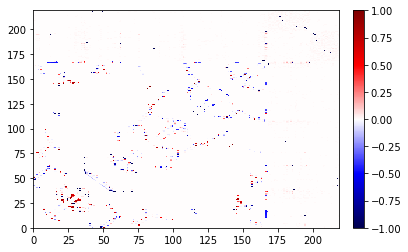

In [11]:
%%time
diff.residue_contacts.plot(cmap='seismic', vmin=-1, vmax=1);

You could have created the same object with:

```python
diff = ContactDifference(trajectory_contact, frame_contacts)
```

but the simple notation using `-` is much more straightforward. However, note that `ContactDifference` makes a difference between the *frequencies* in the two objects, not the absolute count. Otherwise the trajectory would swamp the single frame, and there would be no blue in that picture!

### Plot more than one ContactObject in a figure.

It can be benificial to look at the contact maps of multiple different trajectories, or representations next to eachother in the same figure. This can be done by using `plot_axes(ax=ax)` after making `subplots`.

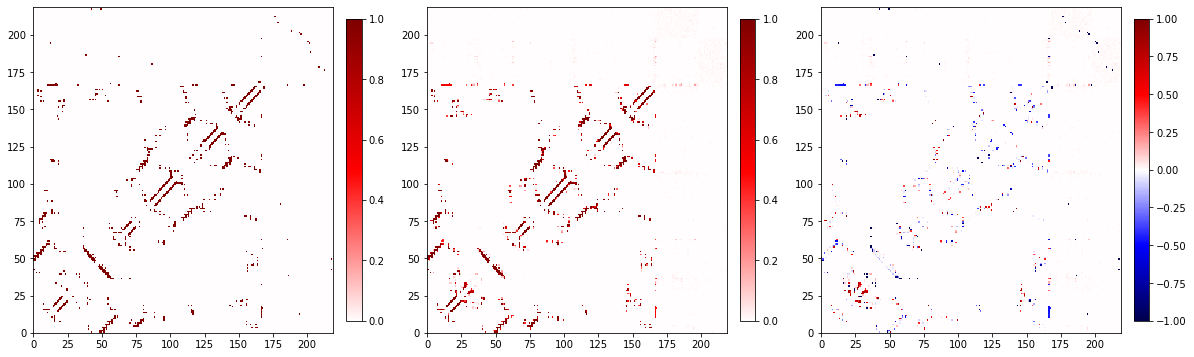

In [12]:
# Make a subplot with 1 row but three columns and a bigger figsize
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# Flatten the axis to a list
axs = axs.flatten()

# Make a list of the contact objects we want to plot in this case: frame, trajectory, difference
contacts = [frame_contacts, trajectory_contacts, diff]

# Now loop and make the plot
for ax, contact in zip(axs, contacts):
    contact.residue_contacts.plot_axes(ax=ax)

### List the residue contacts that show the most difference

First we look at the contacts that are much more important in the trajectory than the frame. Then we look at the contacts that are more important in the frame than the trajectory.

The `.most_common()` method gives a list of the contact pairs and the frequency, sorted by frequency. See also `collections.Counter.most_common()` in the standard Python `collections` module.

Here we do this with the `ContactDifference` we created, although it works the same for `ContactFrequency` and `ContactMap` (with the single-frame contact map, the ordering is a bit nonsensical, since every entry is either 0 or 1).

In [13]:
%%time
# residue contact more important in trajectory than in frame (near +1)
diff.residue_contacts.most_common()[:10]

CPU times: user 2.04 ms, sys: 34 µs, total: 2.07 ms
Wall time: 2.08 ms


[([ALA146, GLN22], 0.9900990099009901),
 ([PHE82, PHE141], 0.9801980198019802),
 ([ILE84, GLU143], 0.9702970297029703),
 ([ALA83, LYS117], 0.9702970297029703),
 ([PHE90, ALA130], 0.9702970297029703),
 ([ALA146, ASN116], 0.9702970297029703),
 ([LEU113, ILE139], 0.9504950495049505),
 ([ALA155, VAL152], 0.9504950495049505),
 ([LEU19, LEU79], 0.9405940594059405),
 ([VAL81, ILE93], 0.9405940594059405)]

In [14]:
# residue contact more important in frame than in trajectory (near -1)
list(reversed(diff.residue_contacts.most_common()))[:10]
# alternate: diff.residue_contacts.most_common()[:-10:-1] # (thanks Sander!)

[([THR50, CL6865], -0.9900990099009901),
 ([NA6824, CL6860], -0.9900990099009901),
 ([TYR40, TYR32], -0.9900990099009901),
 ([NA6828, THR87], -0.9900990099009901),
 ([CL6849, NA6842], -0.9900990099009901),
 ([NA6834, SER39], -0.9900990099009901),
 ([ALA59, GLU37], -0.9900990099009901),
 ([PRO34, ASP38], -0.9900990099009901),
 ([GLN25, ASP30], -0.9900990099009901),
 ([NA6842, GLY13], -0.9900990099009901)]

### List the atoms contacts most common within a given residue contact

First let's select a few residues from the topology. Note that GTP has residue ID 201 in the PDB sequence, even though it is only residue 166 (counting from 0) in the topology. This is because some of the protein was removed, and therefore the PDB is missing those residues. The topology only counts the residues that are actually present.

In [15]:
val81 = topology.residue(80)
asn116 = topology.residue(115)
gtp201 = topology.residue(166)
print(val81, asn116, gtp201)

VAL81 ASN116 GTP201


We extended the standard `.most_common()` to take an optional argument. When the argument is given, it will filter the output to only include the ones where that argument is part of the contact. For example, the following gives the residues most commonly in contact with GTP.

In [16]:
for contact in trajectory_contacts.residue_contacts.most_common(gtp201):
    if contact[1] > 0.1:
        print(contact)

([GTP201, LEU120], 0.6435643564356436)
([GTP201, ASP119], 0.6237623762376238)
([LYS147, GTP201], 0.6138613861386139)
([SER145, GTP201], 0.594059405940594)
([ALA146, GTP201], 0.594059405940594)
([LYS117, GTP201], 0.594059405940594)
([ASP33, GTP201], 0.5742574257425742)
([GLY12, GTP201], 0.5643564356435643)
([GLY13, GTP201], 0.5544554455445545)
([VAL14, GTP201], 0.5346534653465347)
([ALA11, GTP201], 0.5346534653465347)
([ALA18, GTP201], 0.5247524752475248)
([GTP201, GLY15], 0.5247524752475248)
([SER17, GTP201], 0.5247524752475248)
([GTP201, LYS16], 0.5247524752475248)
([ASN116, GTP201], 0.4752475247524752)
([ASP57, GTP201], 0.40594059405940597)
([GTP201, GLU63], 0.39603960396039606)
([GLU37, GTP201], 0.3465346534653465)
([VAL29, GTP201], 0.297029702970297)
([NA6833, GTP201], 0.2079207920792079)
([NA6843, GTP201], 0.18811881188118812)
([THR35, GTP201], 0.1485148514851485)
([PRO34, GTP201], 0.1485148514851485)
([NA6829, GTP201], 0.1485148514851485)


We can also find all the atoms, for all residue contacts, that are in contact with a given residue, and return that sorted by frequency.

In [17]:
diff.most_common_atoms_for_residue(gtp201)[:15]

[([GTP201-C6, LYS117-CB], 0.5346534653465347),
 ([GTP201-O6, LYS117-CA], 0.5247524752475248),
 ([GTP201-C6, LYS117-CA], 0.5247524752475248),
 ([GTP201-C8, GLY15-CA], 0.5148514851485149),
 ([GTP201-N7, GLY15-CA], 0.5148514851485149),
 ([GTP201-O2', ASP33-CG], 0.5148514851485149),
 ([GLY13-C, GTP201-PB], 0.49504950495049505),
 ([LYS117-N, GTP201-O6], 0.49504950495049505),
 ([GTP201-C2, LYS147-CB], 0.49504950495049505),
 ([GTP201-O3A, GLY13-C], 0.48514851485148514),
 ([GTP201-O2', ASP33-OD2], 0.48514851485148514),
 ([GTP201-O6, ASN116-OD1], 0.4752475247524752),
 ([GTP201-N7, ASN116-ND2], 0.45544554455445546),
 ([ASN116-CG, GTP201-O6], 0.45544554455445546),
 ([GTP201-O6, LYS117-CB], 0.45544554455445546)]

Finally, we can look at which atoms are most commonly in contact within a given residue contact pair.

In [18]:
trajectory_contacts.most_common_atoms_for_contact([val81, asn116])

[([ASN116-CB, VAL81-CG1], 0.9702970297029703),
 ([VAL81-CG1, ASN116-CG], 0.24752475247524752),
 ([VAL81-CG1, ASN116-ND2], 0.21782178217821782),
 ([VAL81-CG1, ASN116-N], 0.0594059405940594)]

## Changing the defaults

This sections covers several options that you can modify to make the contact maps faster, and to focus on what you're most interested in.

The first three options change which atoms are included as possible contacts. We call these `query` and `haystack`, and although they are conceptually equivalent, the algorithm is designed such that the query should have fewer atoms than the haystack.

Both of these options take a list of atom index numbers. These are most easily created using MDTraj's atom selection language.

In [19]:
# the default selection is
default_selection = topology.select("not water and symbol != 'H'")
print(len(default_selection))

1408


### Using a different query

MDTraj allows queries based on different numbering systems: `resid` and `resSeq`. The `resid` is the internally-used residue number, and starts from 0. On the other hand, `resSeq` is the residue number given in the PDB, which usually starts from 1 (and is the number we usually refer to in literature). More details can be found in the [documentation on MDTraj's atom selection language](http://mdtraj.org/latest/atom_selection.html).

In [20]:
switch1 = topology.select("resSeq 32 to 38 and symbol != 'H'")
switch2 = topology.select("resSeq 59 to 67 and symbol != 'H'")
gtp = topology.select("resname GTP and symbol != 'H'")
mg = topology.select("element Mg")
cations = topology.select("resname NA or resname MG")
sodium = topology.select("resname NA")

In [21]:
%%time
sw1_contacts = ContactFrequency(trajectory=traj, query=switch1)

CPU times: user 7.63 s, sys: 188 ms, total: 7.82 s
Wall time: 691 ms


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc7b5f45150>)

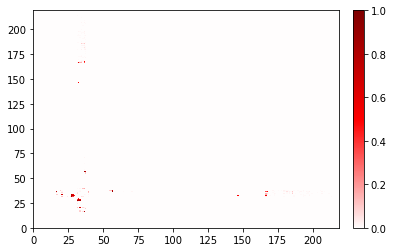

In [22]:
sw1_contacts.residue_contacts.plot(cmap='seismic', vmin=-1, vmax=1)

### Using a different haystack

In [23]:
%%time
cations_switch1 = ContactFrequency(trajectory=traj, query=cations, haystack=switch1)

CPU times: user 899 ms, sys: 16.5 ms, total: 916 ms
Wall time: 90.8 ms


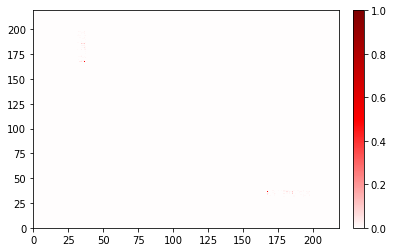

In [24]:
fig, ax = cations_switch1.residue_contacts.plot(cmap='seismic', vmin=-1, vmax=1)

Now we'll plot again, but we'll change the `x` and `y` axes so that we only see switch 1 (the haystack) along `x` and cations (the query) along `y`:

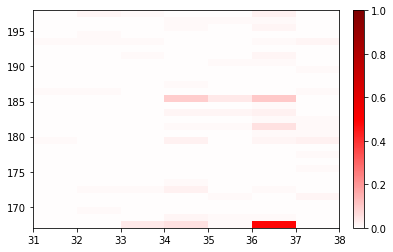

In [25]:
fig, ax = cations_switch1.residue_contacts.plot(cmap='seismic', vmin=-1, vmax=1)
ax.set_xlim(*cations_switch1.haystack_residue_range) 
ax.set_ylim(*cations_switch1.query_residue_range);

Here, of course, the boxes are much larger, and are long rectangles instead of squares. The box represents the residue number (in the `resid` numbering system) that is to its left and under it. So the most significant contacts here are between residue 36 and the ion listed as residue 167. Let's see just how frequently that contact is made:

In [26]:
print(cations_switch1.residue_contacts.counter[frozenset([36, 167])])

0.48514851485148514


So about half the time. Now, which residue/ion are these? Remember, these indices start at 0, even though the tradition in science (and the PDB) is to count from 1. Furthermore, the PDB residue numbers for the ions skip the section of the protein that has been removed. But we can easily obtain the relevant residues:

In [27]:
print(traj.topology.residue(36))
print(traj.topology.residue(167))

GLU37
MG202


So this is a contact between the Glu37 and the magnesium ion (which is listed as residue 202 in the PDB).

### Changing how many neighboring residues are ignored

By default, we ignore atoms from 2 residues on either side of the given residue (and in the same `chain`). This is easily changed. However, even when you say to ignore no neighbors, you still ignore the residue's interactions with itself.

Note: for non-protein contacts, the `chain` is often poorly defined. In this example, the GTP and the Mg are listed sequentially in residue order, and therefore they are considered "neighbors" and their contacts are ignored.

In [28]:
%%time
ignore_none = ContactFrequency(trajectory=traj, n_neighbors_ignored=0)

CPU times: user 1min 9s, sys: 1.29 s, total: 1min 11s
Wall time: 6.96 s


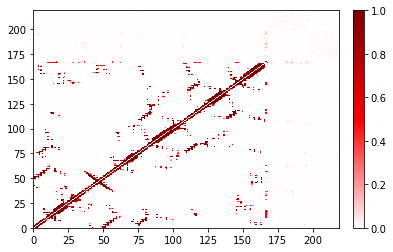

In [29]:
ignore_none.residue_contacts.plot(cmap='seismic', vmin=-1, vmax=1);

### Using a different cutoff

The size of the cutoff has a large effect on the performance. The default is (currently) 0.45nm.

In [30]:
%%time
large_cutoff = ContactFrequency(trajectory=traj, cutoff=1.5)

CPU times: user 5min 37s, sys: 5.04 s, total: 5min 42s
Wall time: 2min 7s


The cost of the built-in plot function also depends strongly on the number of contacts that are made. It is designed to work well for sparse matrices; as the matrix gets less sparse, other approaches may be better. Here's an example:

CPU times: user 19.9 s, sys: 104 ms, total: 20 s
Wall time: 20 s


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc7b55ff0d0>)

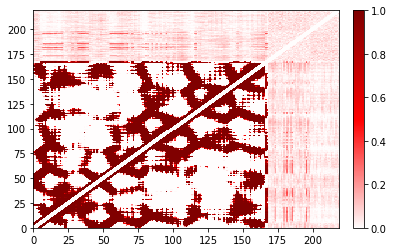

In [31]:
%%time
large_cutoff.residue_contacts.plot(cmap='seismic', vmin=-1, vmax=1);

CPU times: user 2.37 s, sys: 4.15 ms, total: 2.37 s
Wall time: 2.37 s


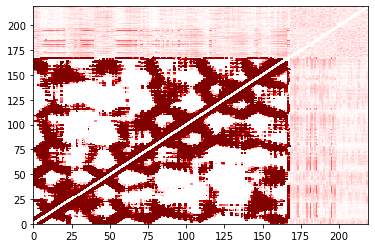

In [32]:
%%time
import matplotlib
cmap = matplotlib.pyplot.get_cmap('seismic')
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

plot = matplotlib.pyplot.pcolor(large_cutoff.residue_contacts.df, cmap='seismic', vmin=-1, vmax=1)
plot.cmap.set_under(cmap(norm(0)));

In this case, using the `pandas.DataFrame` representation (obtained using `.df`) is faster. On the other hand, try using this approach on the atom-atom picture at the top! That will take a while.

You'll notice that these may not be pixel-perfect copies. This is because the number of pixels doesn't evenly divide into the number of residues. You can improve this by increasing the resolution (`dpi` in matplotlib) or the figure size. However, in both versions you can see the overall structure quite clearly. In addition, the color bar is only shown in the built-in version.